In [3]:
# !pip install transformers
# !pip install torch
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.3 MB 19.1 MB/s 
     |████████████████████████████████| 3.3 MB 29.1 MB/s 
     |████████████████████████████████| 1.2 MB 36.3 MB/s 
     |████████████████████████████████| 61 kB 401 kB/s 
     |████████████████████████████████| 596 kB 30.3 MB/s 
     |████████████████████████████████| 895 kB 30.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=2149542d6c151c73bc8b3301864c5a84b4a19e2681ba28088a94f517e0927d47
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/MyDrive'

import os 
os.chdir(PROJECT_ROOT)
DATA_PATH = os.path.join(PROJECT_ROOT, 'Quotebank_limunADA')

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

import torch 
import torch.nn as nn 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np 
import pickle
import bz2
import json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)

    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)

    return lda_tokens


def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


def get_tokens_per_quote(path_to_file, print_step=5e4, num_instances=None):

    tokens_per_quote = {}
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):
            if i % int(print_step) == 0:
                print(f'Instance {i}')

            if num_instances is not None:
                if i == num_instances:
                    break 

            # loading a sample and checking the speaker
            instance = json.loads(instance) 
            tokens = prepare_text_for_lda(instance['quotation'])

            tokens_per_quote[instance['quoteID']] = tokens 
    
    return tokens_per_quote



In [65]:
# path_to_file = os.path.join(DATA_PATH, 'quotes-democrates-2019.json.bz2')
path_to_file = os.path.join(DATA_PATH, 'quotes-republicans-2019.json.bz2')

tokens_per_quote = get_tokens_per_quote(path_to_file, num_instances=None)


Instance 0
Instance 50000
Instance 100000
Instance 150000
Instance 200000
Instance 250000
Instance 300000
Instance 350000
Instance 400000
Instance 450000
Instance 500000
Instance 550000
Instance 600000
Instance 650000
Instance 700000
Instance 750000
Instance 800000


In [67]:
tokens_per_quote_strings = [' '.join(quote) for k, quote in tokens_per_quote.items()]
tokens_per_quote_strings[:10]


['immoral harmful hurtful',
 'answer problem dangerous three country journey hands dangerous traffic network planet public policy encourage',
 'cabinet looking number option obviously vet legal making everything board concern access public',
 'urgent responsible opioids crisis accountable victim recover inflict sackler looting purdue remedied',
 'percent direct quote political writings founding',
 'wonderful today thank great woman pentagon working',
 'bunch professional nerd',
 'crazy end crazy fight plenty fallujah',
 'schedule today nation leaders trade transportation border staff',
 'everybody make mistake']

In [68]:
embeddings = model.encode(
    tokens_per_quote_strings,
    show_progress_bar=True,
    device=DEVICE,
    batch_size=32 if str(DEVICE) == 'cuda' else 1
    )

print(embeddings.shape)


Batches:   0%|          | 0/25713 [00:00<?, ?it/s]

(822786, 384)


In [69]:
os.makedirs(os.path.join(DATA_PATH, 'SBERT'), exist_ok=True)
party = 'republicans'
year = '2019'

pickle.dump(
    embeddings, 
    open(os.path.join(DATA_PATH, 'SBERT', f'embeddings_{party}_{year}.pkl'), 'wb')
    )


In [70]:
topics = ['healthcare', 'government', 'china']

topics_embeddings = model.encode(topics)

print(topics_embeddings.shape)

(3, 384)


In [71]:
party = 'republicans'
year = '2019'

embeddings = pickle.load(
    open(os.path.join(DATA_PATH, 'SBERT', f'embeddings_{party}_{year}.pkl'), 'rb')
    )

print(embeddings.shape)

(822786, 384)


In [72]:
compute_cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

for topic, topic_embedding in zip(topics, topics_embeddings):
    print(topic)

    cosine_similarity = compute_cosine_similarity(
        torch.from_numpy(embeddings), torch.from_numpy(topic_embedding)
        )

    break

healthcare


In [73]:
def get_instances_at_indexes(path_to_file, indexes):

    instances = []
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):

            if i not in indexes:
                continue
            else:                
                # loading a sample and checking the speaker
                instance = json.loads(instance) 
                instances.append(instance['quotation'])

    return instances

In [74]:
cosine_similarity_sorted, most_similar_indexes = \
    torch.sort(cosine_similarity, descending=True)

In [75]:
cosine_similarity_sorted[:100]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9051, 0.8866, 0.8743, 0.8743, 0.8613,
        0.8248, 0.8196, 0.8191, 0.8058, 0.8058, 0.7928, 0.7895, 0.7880, 0.7880,
        0.7863, 0.7861, 0.7811, 0.7777, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712,
        0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712,
        0.7699, 0.7690, 0.7687, 0.7687, 0.7653, 0.7641, 0.7586, 0.7577, 0.7566,
        0.7561, 0.7551, 0.7529, 0.7525, 0.7525, 0.7525, 0.7525, 0.7525, 0.7525,
        0.7525, 0.7521, 0.7424, 0.7424, 0.7411, 0.7405, 0.7399, 0.7384, 0.7361,
        0.7349, 0.7335, 0.7328, 0.7328, 0.7308, 0.7308, 0.7308, 0.7300, 0.7290,
        0.7286, 0.7280, 0.7276, 0.7254, 0.7240, 0.7237, 0.7221, 0.7216, 0.7214,
        0.7213, 0.7211, 0.7201, 0.7196, 0.7191, 0.7107, 0.7095, 0.7094, 0.7086,
        0.7084, 0.7073, 0.7072, 0.7064, 0.7062, 0.7059, 0.7054, 0.7051, 0.7051,
        0.7035])

In [76]:
most_similar_quotes = get_instances_at_indexes(
    path_to_file, np.array(most_similar_indexes[:100])
    )

most_similar_quotes

['Healthcare Tax Relief Act,',
 "When I left the hospital, they gave me essentially a CD-ROM and they said here's his health care information,",
 "There's still a great deal of work to do on healthcare,",
 'one of the biggest concerns Americans have about healthcare.',
 "health care for people who don't have it.",
 'lies about health care.',
 "No.. It's not for us to have anything to do with your healthcare system,",
 'will be truly great HealthCare that will work for America.',
 'They have healthcare right now,',
 'developing a really great HealthCare plan.',
 'I get all my health care from the VA,',
 "I ask you, as hospital providers, to set the bar... don't make us do it,",
 'Patients can look and see how their own hospital is being operated,',
 'want to take away your health care',
 'I went to the hospitals,',
 'We had health care, it was done,',
 'very important health care bill',
 "He'd look at me, and he'd say `Good job, John, for getting healthcare for every American, but why a

In [77]:
for pair in zip(cosine_similarity_sorted[:100], most_similar_quotes):
    print(f'{float(pair[0])} {pair[1]}')


1.0000001192092896 Healthcare Tax Relief Act,
1.0000001192092896 When I left the hospital, they gave me essentially a CD-ROM and they said here's his health care information,
1.0000001192092896 There's still a great deal of work to do on healthcare,
1.0000001192092896 one of the biggest concerns Americans have about healthcare.
0.905136227607727 health care for people who don't have it.
0.8866458535194397 lies about health care.
0.8742896914482117 No.. It's not for us to have anything to do with your healthcare system,
0.8742895722389221 will be truly great HealthCare that will work for America.
0.8612651824951172 They have healthcare right now,
0.8247767090797424 developing a really great HealthCare plan.
0.8195688128471375 I get all my health care from the VA,
0.8190968632698059 I ask you, as hospital providers, to set the bar... don't make us do it,
0.8058189153671265 Patients can look and see how their own hospital is being operated,
0.8058189153671265 want to take away your health

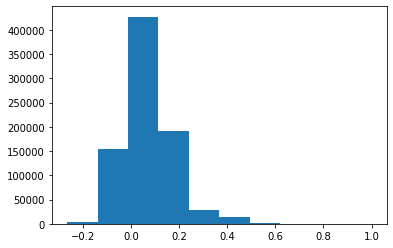

In [78]:
# REPUBLICANS
import matplotlib.pyplot as plt 

plt.hist(np.array(cosine_similarity))
plt.show()

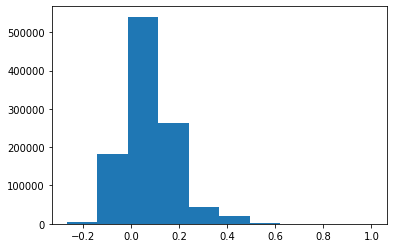

In [64]:
# DEMOCRATES
import matplotlib.pyplot as plt 

plt.hist(np.array(cosine_similarity))
plt.show()

# OLD STUFF


In [ ]:
import matplotlib.pyplot as plt

def scatter_classes_with_markers(embeddings_pca, quotes_and_labels):
  pos_embeddings_pca = []
  neg_embeddings_pca = []

  for ind, (quote, label) in enumerate(quotes_and_labels):
    if label == 1:
      pos_embeddings_pca.append(list(embeddings_pca[ind, :]))
    else:
      neg_embeddings_pca.append(list(embeddings_pca[ind, :]))

  pos_embeddings_pca = np.array(pos_embeddings_pca)
  neg_embeddings_pca = np.array(neg_embeddings_pca)

  plt.figure(figsize=(10, 5))
  plt.scatter(
      pos_embeddings_pca[:, 0], pos_embeddings_pca[:, 1], 
      marker='+', s=200, c='b'
      )
  plt.scatter(
      neg_embeddings_pca[:, 0], neg_embeddings_pca[:, 1], 
      marker='_', s=200, c='r'
      )

  plt.grid()

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np 

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
quotes_and_labels = [
  ('I adore ice cream', 1), 
  ('I hate ice cream', 0),
  ('I hate fucking london because of rain', 0),
  ('Jana is a dumbass', 0),
  ('I am beatiful', 1),
  ('hate hate hate you', 0),
  ('she is a very smart cute girl', 1),
  ('love love love love beautiful', 1),
  ('bad ugly smelly stupid', 0),
  ('stupid stupid bad worse the worst', 0),
  ('beautiful beautiful pretty very nice nice', 1),
  ('which almost everyone, other than crooked hillary clinton hillary diane rodham clinton comey', 0),
  ('dnc wanted, same as the crooked hillary fiasco. the bernie people should come', 0),
  ('we will eliminate the obama, clinton defense plan and rebuild our badly', 0),
  ('before the war ever started. but hillary clinton learned nothing from iraq. because', 0),
  ('dishonest and distorted media pushing crooked hillary -- but also at many polling', 0),
  ("she's still left over from the clinton administration", 1)
  ]

quotes = [pair[0] for pair in quotes_and_labels]

embeddings = model.encode(quotes)
print(embeddings.shape)

(17, 384)


In [ ]:
out_features = 2
quote_num = embeddings.shape[0]
pca = PCA(n_components=out_features)

embeddings_pca = pca.fit_transform(embeddings)


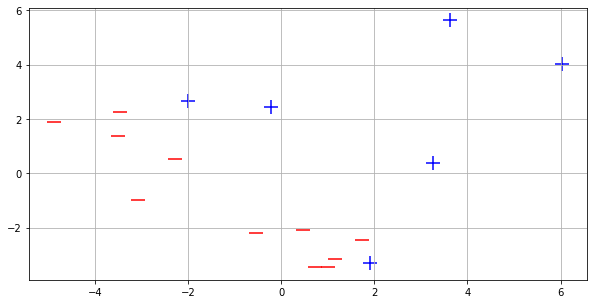

In [ ]:
scatter_classes_with_markers(embeddings_pca, quotes_and_labels)

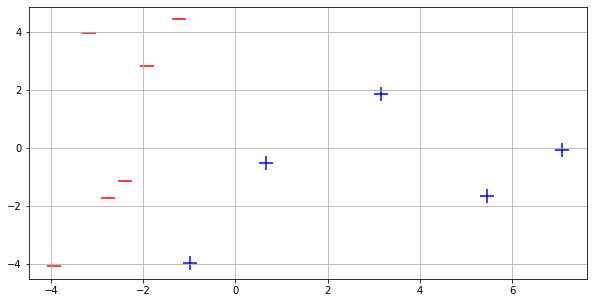